In [1]:
# import and initialize
from pymcmcstat.MCMC import MCMC 
import pandas as pd
import numpy as np
import mph
experiment = pd.read_csv("../Data/bend/centerFreqResponse.csv")[20:]
# Mobility value calculated from input data and converted to torch
mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
freq = experiment["freq"].values
goal = mobility[np.logical_and(mobility>0.1, mobility<0.75)]


In [80]:

client = mph.start()
#modelComsol = client.load("../comsol/beamSimpleTest1.mph")
modelComsol = client.load("../comsol/TestComsol.mph")
goalFreq = freq[np.logical_and(mobility>0.1, mobility<0.75)]
def solveComsol(modelComsol, param):#, freq=10):
    
    # Update parameters
    E, rho, eta = param
    rho, eta, E = normalization(rho, eta, E)
    modelComsol.parameter('youngs', str(E)+' [Pa]')
    modelComsol.parameter('density', str(rho)+' [kg/m^3]')
    modelComsol.parameter('eta', str(eta))


    # Solving comsol FEM
    modelComsol.solve("Study 2")
    #comsolResults1 = torch.tensor(modelComsol.evaluate("comp1.point2"))
    comsolResults = modelComsol.evaluate("comp1.point2")

    return abs(comsolResults)
def normalization(rho, eta, E):
    E_theo=9.7e10
    E_var_init =5.0e9
    rho_theo=8000.0
    rho_var_init =250.0
    eta_mean=0.00505
    eta_var_init = 0.006
    
    rho_norm = rho*rho_var_init + rho_theo
    eta_norm = eta*eta_var_init + eta_mean
    E_norm = E*E_var_init + E_theo

    return rho_norm, eta_norm, E_norm
    
def mobilityFuncModel(param):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    global goalFreq
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12
    param
    E, rho, eta = param
    rho, eta, E = normalization(rho, eta, E)
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*np.pi*goalFreq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = np.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
    D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*np.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)

com.comsol.util.exceptions.FlException: Exception:
	com.comsol.util.exceptions.FlException: Not connected to a server
Messages:
	Not connected to a server


In [3]:
goalFreq

array([ 115. ,  115.5,  116. ,  116.5,  117. ,  117.5,  118. ,  118.5,
        119. ,  119.5,  121. ,  121.5,  122. ,  122.5,  123. ,  123.5,
        124. ,  124.5,  125. ,  125.5,  126. ,  126.5,  641. ,  641.5,
        642. ,  642.5,  643. ,  643.5,  644. ,  644.5,  645. ,  645.5,
        646. ,  646.5,  647. ,  647.5,  648. ,  648.5,  649. ,  649.5,
        650. ,  650.5,  651. ,  651.5,  652. ,  652.5,  653. ,  653.5,
        654. ,  654.5, 1595.5, 1596. , 1596.5, 1597. , 1597.5, 1598. ,
       1598.5, 1599. , 1599.5, 1600. , 1600.5, 1601. , 1601.5, 1602. ,
       1602.5, 1603. , 1603.5, 1604. , 1604.5, 1605. , 1605.5, 1606. ,
       1606.5, 2976.5, 2977. , 2977.5, 2978. , 2978.5, 2979. , 2979.5,
       2980. , 2980.5, 2981. , 2981.5, 2982. , 2982.5, 2983. , 2983.5])

In [22]:
error = []
# Define sum of squares function
def ssfun(q, data):
    global error
    y = data.ydata[0].T
    y = y[0]
    # Evaluate model
    ymodel = solveComsol(modelComsol, q)
    res = ymodel - y
    print(res)
    error = np.append(error, (res ** 2).sum(axis=0))
    print(np.shape(error))
    return (res ** 2).sum(axis=0)
# Define model settings
mcstat = MCMC()
mcstat.data.add_data_set(goalFreq, goal)
mcstat.model_settings.define_model_settings(
    sos_function=ssfun)
# Define simulation options
mcstat.simulation_options.define_simulation_options( nsimu=5.0e3) # No. of MCMC simulations
# Add model parameters
mcstat.parameters.add_model_parameter(
    name='E',
    theta0=0., # initial value 
    minimum=-0.75, # lower limit 
    maximum=0.75)
mcstat.parameters.add_model_parameter(
    name='rho',
    theta0=0., # initial value 
    minimum=-0.75, # lower limit 
    maximum=0.75) # upper limit
mcstat.parameters.add_model_parameter(
    name='eta',
    theta0=0., # initial value 
    minimum=-0.75, # lower limit 
    maximum=0.75)
# Run simulation
mcstat.run_simulation()




Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         E:  0.00e+00 [    -0.75,      0.75] N( 0.00e+00,      inf)
       rho:  0.00e+00 [    -0.75,      0.75] N( 0.00e+00,      inf)
       eta:  0.00e+00 [    -0.75,      0.75] N( 0.00e+00,      inf)
[ 0.06693728  0.0839359   0.11481997  0.16232821  0.24504841  0.42650884
  0.9459925   1.66216929  0.49850662 -0.13979034 -0.35659369 -0.2124802
 -0.12698324 -0.09703462 -0.0737747  -0.05139996 -0.03892506 -0.03147739
 -0.02596778 -0.02015313 -0.01731797 -0.01538937  0.07195544  0.04706562
  0.02763677  0.00220311 -0.02130067 -0.04273593 -0.06321242 -0.10073833
 -0.14201612 -0.20256102 -0.25402081 -0.36087471 -0.48780756 -0.42627844
 -0.39257758 -0.4544891  -0.32624642 -0.24151684 -0.2032355  -0.1706305
 -0.14185262 -0.12213425 -0.10358905 -0.08978974 -0.07808974 -0.06727517
 -0.05841804 -0.05262058 -0.08582884 -0.09410183 -0.10735743 -0.11993486
 -0.12912135 -0.14612122 -0.15621271 -0.1776

/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_72073/446458157.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) plot_chain_panel. (New function:"from pymcmcstat.mcmcplot import plot_chain_panel") -- Deprecated since version 1.9.0.
  mcpl.plot_chain_panel(chain, names)


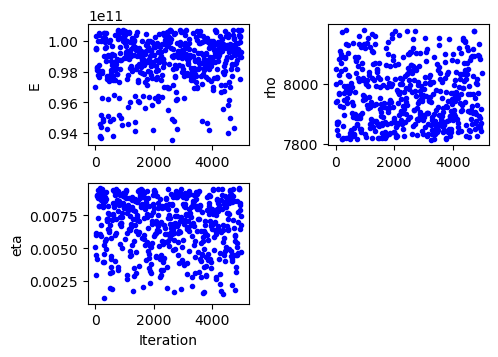

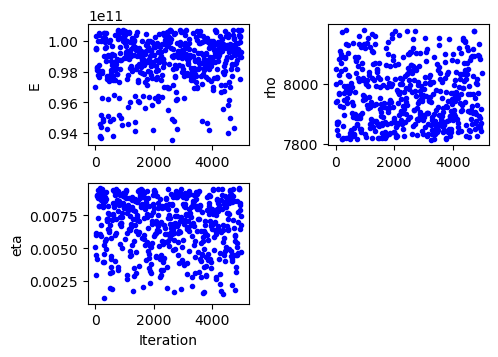

In [52]:
results = mcstat.simulation_results.results
chain = results['chain'] 
names = results['names']
# generate mcmc plots
mcpl = mcstat.mcmcplot # initialize plotting methods
mcpl.plot_chain_panel(chain, names)

In [37]:

results = mcstat.simulation_results.results 
chain = results['chain']
burnin = int(chain.shape[0]/2)
# display chain statistics 
mcstat.chainstats(chain[burnin:, :], results)



------------------------------
      name:      mean       std    MC_err       tau    geweke
         E:      0.36      0.30      0.02     10.63      0.97
       rho:     -0.16      0.37      0.03     18.18      0.15
       eta:      0.26      0.34      0.02     14.48      0.88
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 18.76%
Stage 2: 51.80%
Net    : 70.56% -> 3528/5000
---------------
Chain provided:
Net    : 72.48% -> 1812/2500
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_72073/2046878478.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) plot_density_panel. (New function: "from pymcmcstat.mcmcplot import plot_density_panel") -- Deprecated since version 1.9.0.
  mcpl.plot_density_panel(chain, names)


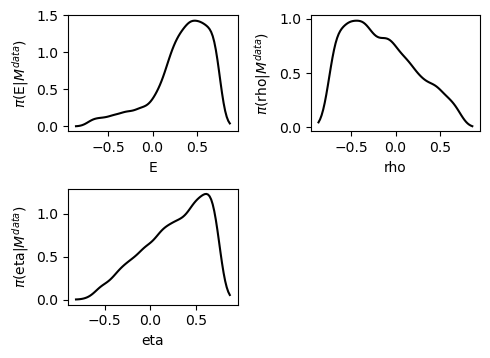

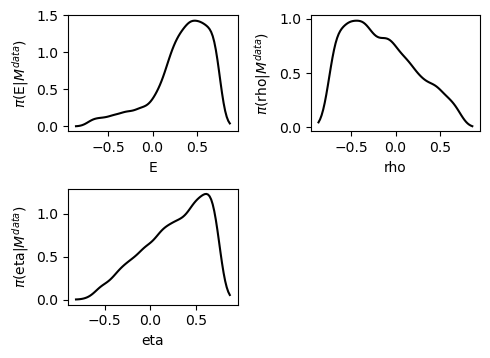

In [28]:
mcpl.plot_density_panel(chain, names)

/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_72073/752537136.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) plot_pairwise_correlation_panel. (New function: "from pymcmcstat.mcmcplot import plot_pairwise_correlation_panel") -- Deprecated since version 1.9.0.
  mcpl.plot_pairwise_correlation_panel(chain[burnin:,:], names)


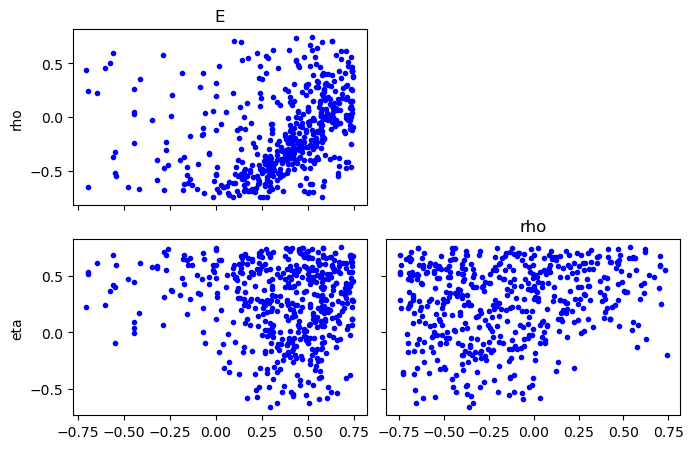

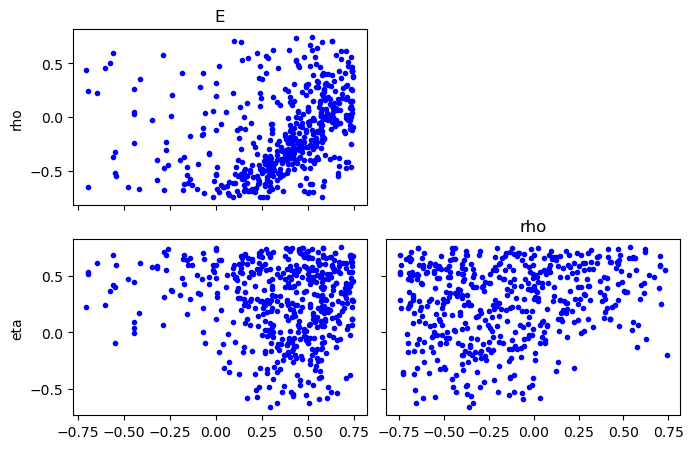

In [29]:
mcpl.plot_pairwise_correlation_panel(chain[burnin:,:], names)

In [38]:
chain[:,1], chain[:,2], chain[:,0] = normalization(chain[:,1], chain[:,2], chain[:,0])

/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_72073/2046878478.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) plot_density_panel. (New function: "from pymcmcstat.mcmcplot import plot_density_panel") -- Deprecated since version 1.9.0.
  mcpl.plot_density_panel(chain, names)


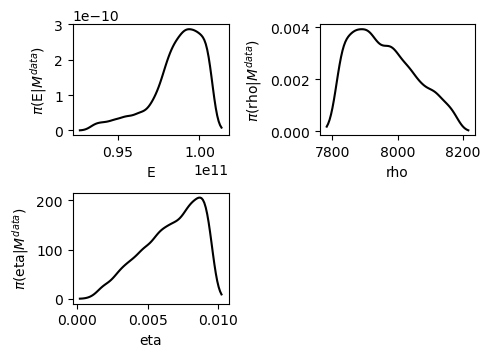

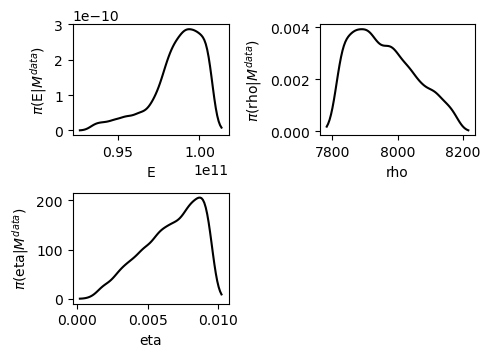

In [51]:
mcpl.plot_density_panel(chain, names)

In [43]:
from scipy import stats
mode_E = stats.mode(chain[:,0], keepdims=True)[0]
mode_rho = stats.mode(chain[:,1], keepdims=True)[0]
mode_eta = stats.mode(chain[:,2], keepdims=True)[0]
print(mode_E, mode_rho, mode_eta)

[1.00708267e+11] [8106.79627272] [0.00572769]


In [53]:
def solveComsol(modelComsol, param):#, freq=10):
    
    # Update parameters
    E, rho, eta = param
    modelComsol.parameter('youngs', str(E)+' [Pa]')
    modelComsol.parameter('density', str(rho)+' [kg/m^3]')
    modelComsol.parameter('eta', str(eta))


    # Solving comsol FEM
    modelComsol.solve("Study 2")
    #comsolResults1 = torch.tensor(modelComsol.evaluate("comp1.point2"))
    comsolResults = modelComsol.evaluate("comp1.point2")

    return abs(comsolResults)

In [3]:

def solveComsol(modelComsol, param):#, freq=10):
    
    # Update parameters
    E, rho, eta = param
    modelComsol.parameter('youngs', str(E)+' [Pa]')
    modelComsol.parameter('density', str(rho)+' [kg/m^3]')
    modelComsol.parameter('eta', str(eta))


    # Solving comsol FEM
    modelComsol.solve("Study 2")
    #comsolResults1 = torch.tensor(modelComsol.evaluate("comp1.point2"))
    comsolResults = modelComsol.evaluate("comp1.point2")
    ref = modelComsol.evaluate("comp1.point1")
    result = comsolResults/ref

    return abs(result)
    
client = mph.start()
#modelComsol = client.load("../comsol/beamSimpleTest1.mph")
modelComsol = client.load("../comsol/TestComsol.mph")
comsolResults = solveComsol(modelComsol, [1.00708267e+11, 8106.79627272, 0.00572769])

In [46]:
mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
freq = experiment["freq"].values

(50, 3000)

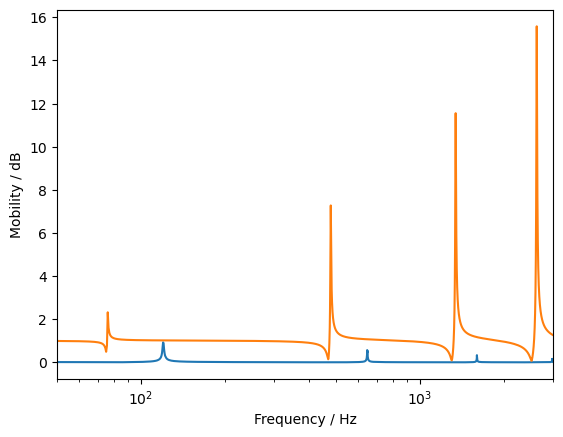

In [9]:
plt.plot(freq, mobility)
plt.plot(np.arange(50, 3000.5, 0.5), 1/comsolResults)
plt.xscale("log")
plt.xlabel("Frequency / Hz")
plt.ylabel("Mobility / dB")
plt.xlim([50, 3000])


In [59]:
print(names)

['E', 'rho', 'eta']


Text(0.001, 175, 'Estimated Eta: 0.0057')

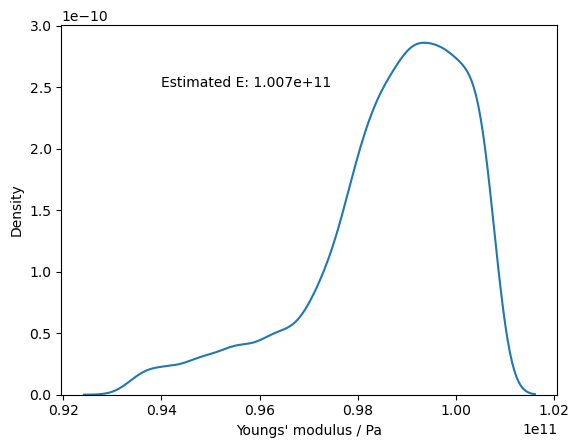

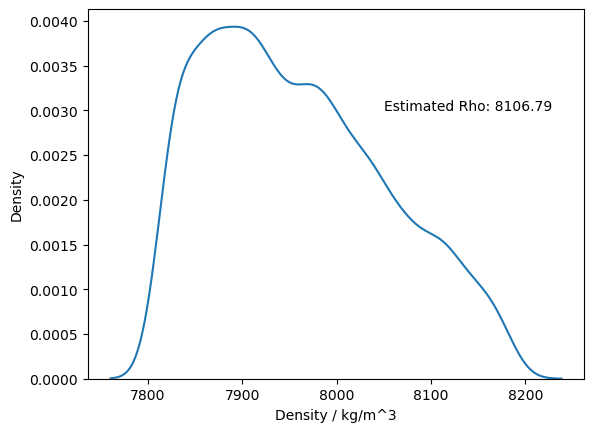

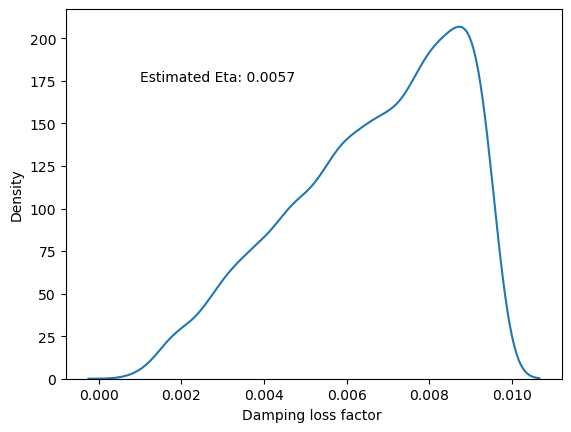

In [77]:
import seaborn as sns
plt.figure()
sns.kdeplot(chain[:,0])
plt.xlabel("Youngs' modulus / Pa")
plt.text(x=0.94e11, y=2.5e-10,s="Estimated E: 1.007e+11")
plt.figure()
sns.kdeplot(chain[:,1])
plt.xlabel("Density / kg/m^3")
plt.text(x=8050, y=0.003,s="Estimated Rho: 8106.79")
plt.figure()
sns.kdeplot(chain[:,2])
plt.xlabel("Damping loss factor ")
plt.text(x=0.001, y=175,s="Estimated Eta: 0.0057")